- First, do lower half with replogle if possible
- If not clear, then do upper AND? lower half with varying number of perturbations, show that effect changes with number of perts?

In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.auto import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

In [2]:
DATADIR = Path('/data/gpfs-1/users/peidlis_c/work/data/perturbation_resource_paper')
TEMPDIR = Path("/fast/scratch/users/peidlis_c/perturbation_resource_paper/")

def leftsided_chebyshev_nodes(N):
    # Takes negative chebyshev nodes of first kind, forces 0 to be included, then adds 1 to all.
    return np.polynomial.chebyshev.chebpts1(N*2+1)[:(N+1)] + 1

>"The authors perform PCA on the top 2000 highly variable genes. Choosing this feature set across all cells and conditions is likely to be biased towards perturbation with the largest effect size. One question is whether it would be feasible to run the pipeline across all expressed genes for each genotype given some cutoff (genes expressed in at least 5-10% of cells). Another alternative would be to define HVGs across subsets composed of each perturbation and unperturbed cells." - Rev3-Major#1

# Effect of number of HVGs on E-distance

In [4]:
from scperturb import edist, onesided_pca_distances, etest, self_pca_distances

dataset = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(TEMPDIR / f'tmp_data_{dataset}.h5')
control = 'control'
groupby = 'perturbation'

iterations = 10

sigs = {}
deltas = {}
tests = {}

# Define sample points ("nodes")

ns_ = leftsided_chebyshev_nodes(iterations)
ns_ = np.array(ns_ * adata.n_vars, dtype=int)
ns_ = np.unique(ns_)
ns = ns_[ns_>0]
n_max = np.max(ns)

In [5]:
eds = {}
for n in tqdm(ns):
    tdata = adata.copy()
    try:
        sc.pp.highly_variable_genes(tdata, n_top_genes=int(n), flavor='seurat_v3', layer='counts')
    except:
        print('Failed to compute HVGs for n=', n)
        continue
    sc.pp.pca(tdata, use_highly_variable=True)
    eds[n] = edist_to_control(tdata, groupby, control='control', verbose=False)

100%|██████████| 11/11 [02:56<00:00, 16.07s/it]


In [6]:
sdf = pd.concat([
    pd.concat(eds)
], axis=1).reset_index()
sdf.columns = ['n', groupby, 'edist']

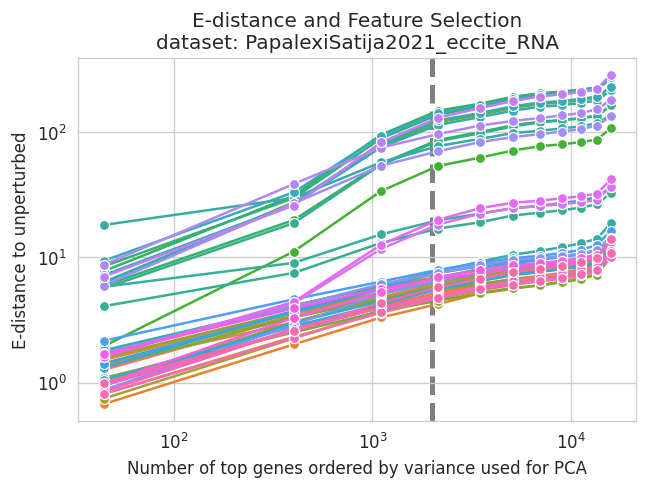

In [7]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(6,4), dpi=120)
lp = sns.lineplot(data=sdf, x='n', y='edist', hue='perturbation', ax=ax, marker='o')
lp.legend_.remove()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Number of top genes ordered by variance used for PCA')
ax.set_ylabel('E-distance to unperturbed')
ax.axvline(2000, linestyle='--', zorder=-1, color='grey', linewidth=3)
ax.set_title(f'E-distance and Feature Selection\ndataset: {dataset}')
pl.show()

# Enriching HVGs by Markers

In [3]:
n = 2000
n_DEGs = 50
dataset = 'ReplogleWeissman2022_K562_essential'

adata = sc.read(TEMPDIR / f'tmp_data_{dataset}.h5')
adata.uns['log1p']['base'] = None  # Known Bug: https://github.com/scverse/scanpy/issues/2239
tdata = adata.copy()

# get DEGs
sc.tl.rank_genes_groups(tdata, groupby='perturbation', reference='control', n_genes=n_DEGs)
top_genes = pd.DataFrame(tdata.uns['rank_genes_groups']['names'])
top_unique = pd.unique(np.concatenate(top_genes.values))

# HVG
sc.pp.highly_variable_genes(tdata, n_top_genes=int(n), flavor='seurat_v3', layer='counts')
sc.pp.pca(tdata)
tdata.obsm['X_pca_hvg'] = tdata.obsm['X_pca']

# HVG + DEGs
tdata.var.loc[top_unique, 'highly_variable'] = True
sc.pp.pca(tdata)
tdata.obsm['X_pca_enriched'] = tdata.obsm['X_pca']

# DEGs alone
tdata.var['highly_variable'] = False
tdata.var.loc[top_unique, 'highly_variable'] = True
sc.pp.pca(tdata)
tdata.obsm['X_pca_specific'] = tdata.obsm['X_pca']

In [4]:
ed_hvg = edist_to_control(tdata, obsm_key='X_pca_hvg')
ed_enriched = edist_to_control(tdata, obsm_key='X_pca_enriched')
ed_specific = edist_to_control(tdata, obsm_key='X_pca_specific')

ed_hvg.columns = ['hvg_distance']
ed_enriched.columns = ['enriched_distance']
ed_specific.columns = ['specific_distance']

ed_all = pd.concat([ed_hvg, ed_enriched, ed_specific], axis=1).reset_index()

100%|██████████| 415/415 [00:02<00:00, 155.87it/s]


In [5]:
ed_all.columns

Index(['perturbation', 'hvg_distance', 'enriched_distance',
       'specific_distance'],
      dtype='object')

In [6]:
from itertools import combinations
combis = [x for x in combinations(['hvg_distance', 'enriched_distance', 'specific_distance'], 2)]

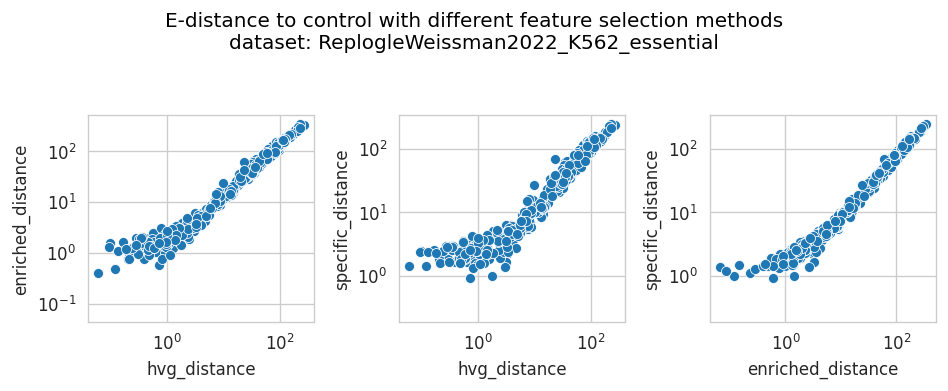

In [7]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, 3, figsize=(8,3), dpi=120)
for i, (a, b) in enumerate(combis):
    ax=axs[i]
    sns.scatterplot(data=ed_all, x=a, y=b, ax=ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
pl.suptitle(f'E-distance to control with different feature selection methods\ndataset: {dataset}', y=1.07)
pl.tight_layout()
pl.show()

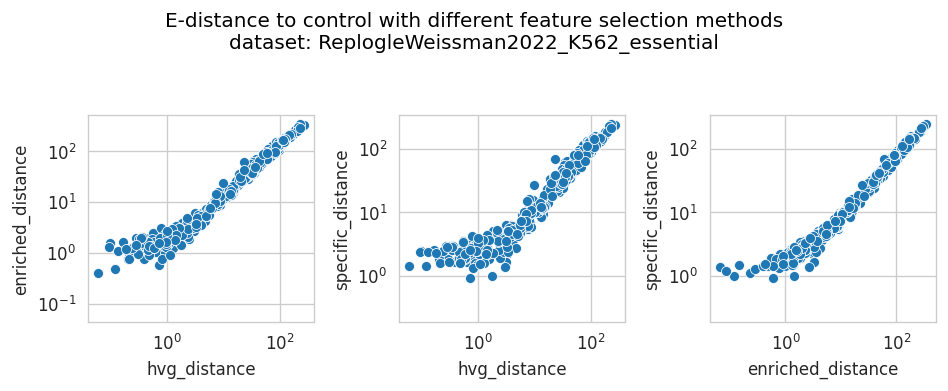

In [7]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, 3, figsize=(8,3), dpi=120)
for i, (a, b) in enumerate(combis):
    ax=axs[i]
    sns.scatterplot(data=ed_all, x=a, y=b, ax=ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
pl.suptitle(f'E-distance to control with different feature selection methods\ndataset: {dataset}', y=1.07)
pl.tight_layout()
pl.show()

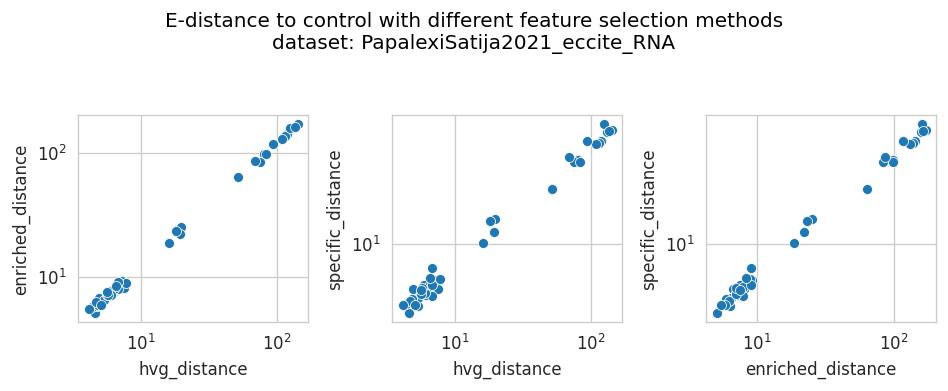

In [33]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, 3, figsize=(8,3), dpi=120)
for i, (a, b) in enumerate(combis):
    ax=axs[i]
    sns.scatterplot(data=ed_all, x=a, y=b, ax=ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
pl.suptitle(f'E-distance to control with different feature selection methods\ndataset: {dataset}', y=1.07)
pl.tight_layout()
pl.show()

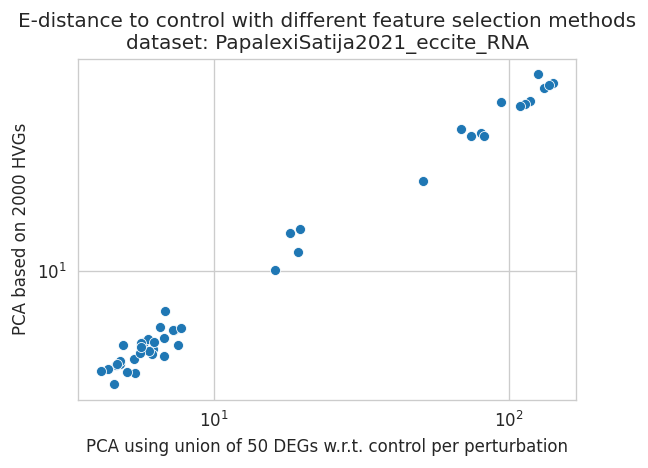

In [44]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(dpi=120, figsize=(5,4))
sns.scatterplot(data=ed_all, x='hvg_distance', y='specific_distance', ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('PCA using union of 50 DEGs w.r.t. control per perturbation')
ax.set_ylabel('PCA based on 2000 HVGs')
pl.title(f'E-distance to control with different feature selection methods\ndataset: {dataset}')
pl.tight_layout()
pl.show()